<a href="https://colab.research.google.com/github/VKapitany/CNN_Introduction/blob/master/CNN_introduction_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a **Convolutional Neural Network** using **Google Colab**

---
# Introduction to Google Collab

You are currently using a Google Colab notebook. Colaboratory, or 'Colab' for short, allows you to write and execute Python in your browser, with: 
* Zero configuration required (don't need to install packages, set anything up)
* Free access to GPUs (plus you don't need to dedicate your own device to training)
* Easy sharing (kinda).
---
Basically, Google Colab creates an IPython **Notebook** (same as what we used in Jupyter) **linked to your Google Drive**. Access notebooks via File>Locate in Drive. 

When you open a notebook, Google creates a session: a **private virtual machine (VM)** linked to your account. This virtual machine behaves like a regular computer: you get RAM, disk space, a processing unit (CPU/GPU/TPU).

Python libraries are already installed in the VM, so you can just import them. When you close the notebook, or after 12 hours from launch, or after some idle period (~15-30? minutes) the session disconects, and the **virtual machine, with any data you loaded into it, including files/networks, is deleted.**

The notebook is autosaved on your Google Drive. You can share it (share options top-right).

---
# Part 1: Classification. Let's get started!

We will:
0. Set the runtime type to GPU
1. Import python libraries
2. Load data (the MNIST digit dataset)
3. Define a convolutional network architecture 
4. Train the architecture to classify digits
5. Predict outputs












# 1. Import libraries

In [ ]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import keras
import tensorflow as tf
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.datasets.mnist import load_data

Using TensorFlow backend.


# 2. Load data

In [ ]:
# Let's load our data (MNIST handwritten digits)
(train_images, train_labels), (test_images, test_labels) = load_data()

print(np.shape(train_images),
      np.shape(train_labels),
      np.shape(test_images),
      np.shape(test_labels))

"""This time, let's set aside some of the data for validation. The purpose of validation is to compare models during model selection.
Why not just use the test data? If we trained on training data, but monitored the model performance on test data and optimised the training
based on it, we would bias our model towards the test data"""


val_images=train_images[0:10000]
val_labels=train_labels[0:10000]
train_images=train_images[10000::]
train_labels=train_labels[10000::]

print(np.shape(train_images),
      np.shape(train_labels),
      np.shape(test_images),
      np.shape(test_labels),
      np.shape(val_images),
      np.shape(val_labels))

11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(50000, 28, 28) (50000,) (10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


``train_images`` - We have 50,000 (28x28) images of handwritten digits to train the classifier.

``train_labels`` - There are 50,000 corresponding labels which tell us which number is represented in the image.

``val_images`` - These 10,000 images are used to optimise the model, without biasing it to perform best on the test set.

``val_labels`` - Corresponding labels for the val_images.

``test_images`` - We'll keep these to test how good our model is at predicting the number in some **unseen** images.

``test_labels`` - Corresponding labels for the test_images. We'll use these as a ground truth to check how many of the test images our model guessed correctly.

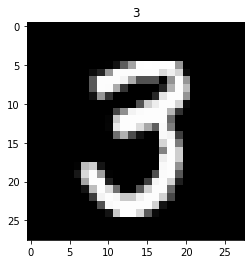

In [ ]:
# Visualise data
plt.figure(1)
index=11
plt.imshow(train_images[index],cmap='binary_r')
plt.title(train_labels[index])
plt.show()

# 3. Define a CNN
---
# Motivation
### Let's recap what we know 
We've taken our first steps towards using neural networks for machine learning: we have downloaded **Anaconda**, created a **virtual environment** where we installed basic **python libraries and tensorflow**, and trained simple, **fully-connected neural networks** for MNIST image classification as well as imaging through random media.

<center><img src="https://raw.githubusercontent.com/VKapitany/CNN_Introduction/master/Google_Colab_files/FNN.gif" width=300>

**[Image Source](https://towardsdatascience.com/understanding-convolutional-neural-networks-221930904a8e);A fully-connected, feed-forward neural network, predicting what digit and image contains. It takes an input of size 28X28, which is flattened into a 28x28=784 dimensional vector. The neural net processes the image, and puts it into one of ten categories. The output encoding is one-hot: it's a string of 0s with single 1, where the position of the 1 indicates the value. In this case, network predicts that the image showed a 2.*
</center>




### Today, we'll train a *Convolutional* Neural Network (CNN)
For image processing, especially when dealing with large images, CNNs are the current gold-standard. A CNN performs **elementwise multiplication** of a **kernel** on small **neighbourhoods** of the input, to build up a **feature** map.

<center><img src="https://raw.githubusercontent.com/VKapitany/CNN_Introduction/master/Google_Colab_files/CNN.gif" width=300>

**[Image Source](https://towardsdatascience.com/understanding-convolutional-neural-networks-221930904a8e);Action of a CNN: a kernel (yellow) is elementwise multiplied (Hadamard product) with an input (green). The sum of the Hadarmard product gives the output feature (pink). A CNN also has a bias termn, not shown in this gif: it is simply added to the sum of the Hadamard product, e.g. if the bias was 1, the top-left pixel of the convolved feature would be 5.*
</center>

#### **The CNN brings 3 major advantages to the table:**


1.   **Sparsity** between the connections of subsequent layers.

<center><img src="https://raw.githubusercontent.com/VKapitany/CNN_Introduction/master/Google_Colab_files/CNN_sparsity.png" width=300>

**[Image Source](https://medium.com/inveterate-learner/deep-learning-book-chapter-9-convolutional-networks-45e43bfc718d); (Top) 1 dimensional CNN. A kernel of size 3 acts on inputs x2, x3 and x4 to give output s3. Since kernels only act on small neighbourhoods of the input, there are a lot fewer connections from one layer to the next than in the densely connected neural network (bottom)!*</center>
2.   **Shared parameters:** the same kernel gets slided along all elements of the input *channel*. This lets the model capture **local connectivity** in the image, while also processing all areas of the image identically. 
3.   CNNs allow us to **capture features** in the image (see Part 2). To achieve this, we will keep the images in their original shape (not flatten them).

In [ ]:
#Define CNN architecture

inp = Input(shape=(28,28,1))
x= Conv2D(filters=32,kernel_size=(3,3),padding='valid',strides=1,activation='relu')(inp)
x=MaxPooling2D(pool_size=(2, 2))(x)
x= Conv2D(64,(3,3),padding='valid',activation='relu')(x)
x=MaxPooling2D((2, 2))(x)
x=Flatten()(x)
x=Dense(100, activation='relu')(x)
out=Dense(10, activation='softmax')(x)

model_1=Model(inputs=inp,outputs=out)
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1601

Let's look at the elements of this model

``Input(shape=(28,28,1))``. This defines the dimensions of the input, in the format: rows, columns, channels. Since we have grayscale images, we have 1 channel only; if we had e.g. RGB images, we'd have 3. However, we need to explicitly define the number of channels, as this is the number of input features the network must act on. 
By looking at the summary, we see that the dimensions of the input layer are actually (None, 28, 28, 1). This is in order: number of inputs, rows, columns, channels. **So we'll need to reshape our input**.

``Conv2D(filters=32, (3,3), padding='valid',strides=1,activation='relu')``: 
 

1.   ``filters=32`` We want to output 32 feature maps. This defines the number of kernels we will need: we apply *number of input channels (feature maps)* x *number of output feature maps* = 1x32 = 32 kernels
2.  ``kernel_size=(3,3)`` Each kernel must have dimensions (3,3) along the rows and columns
3. ``padding='same'`` We want the output to have the same number of rows and columns as the input. To achieve this, we must pad the input with 0s along the edges. With a kernel size of (3,3), this means we must add 1 layer of 0s around every edge; with a kernel size of (5,5), we'd add 2 layers of 0s.

4. ``strides = 1`` How many steps we want the kernel to move at a time (1).. 
5. ``activation = 'relu'``. After the kernels perform the convolution (and the bias is added) the resulting number is input into a a rectified linear unit ('ReLU'). This simple but powerful non-linear activation function outputs 0 if the resulting number was negative, and outputs the number itsself otherwise.


<center><img src="https://raw.githubusercontent.com/VKapitany/CNN_Introduction/master/Google_Colab_files/CNN_strides.gif" width=300>

**[Image Source](https://lilianweng.github.io/lil-log/assets/images/numerical_padding_strides.gif); This image shows filters=1, kernel_size=(3,3), padding='same', strides=2 on a single channel input. Note that padding='same' assumes strides=1 when adding 0s.*
</center>

``MaxPooling`` - The 2nd layer in our model is a dimensionality reduction. This scans a filter with shape ``(2,2)``over the output from the ``Conv2D`` layer and simply takes the maximum value of every step to be the downsampled pixel value. The ``strides`` argument just tells the filter how many pixels to step along during the scan. 

<center><img src="https://raw.githubusercontent.com/VKapitany/CNN_Introduction/master/Google_Colab_files/Maxpooling.gif" width="400"> 

[Image Source](https://www.oreilly.com/radar/wp-content/uploads/sites/3/2019/06/Figure_4-87c227113cdd0b73d842267404d4aa00.gif)Max-pooling by scanning a 2x2 filter in strides of 2 pixels to downsample the output of the previous layer</center>

``Flatten`` Reshapes the most recent layer into a 1-d vector.

``Dense`` - Fully-connected layer. We've already used this layer last time



In [ ]:
#Reshape input
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)
val_images = val_images.reshape(-1, 28, 28, 1)

print('train_images: {}'.format(train_images.shape))
print('test_images : {}'.format(test_images.shape))
print('val_images : {}'.format(val_images.shape))

train_images: (50000, 28, 28, 1)
test_images : (10000, 28, 28, 1)
val_images : (10000, 28, 28, 1)


# 4. Train the architecture

In [ ]:
#Compile model.
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],               
             )
# Stop training the model when the loss on the validation set accuracy doesn't improve for 5 epochs
my_callback=[EarlyStopping(monitor='val_accuracy', 
                      patience=5)]
#Train model
history=model_1.fit(train_images,
                    train_labels,
                    validation_data=[val_images,val_labels],
                    epochs=15,
                    batch_size=512,  
                    shuffle='True',  
                    callbacks=my_callback)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 8s 163us/step - loss: 3.1125 - accuracy: 0.7660 - val_loss: 0.2808 - val_accuracy: 0.9243
Epoch 2/15
50000/50000 [==============================] - 2s 43us/step - loss: 0.1776 - accuracy: 0.9497 - val_loss: 0.1563 - val_accuracy: 0.9557
Epoch 3/15
50000/50000 [==============================] - 2s 43us/step - loss: 0.1034 - accuracy: 0.9700 - val_loss: 0.1095 - val_accuracy: 0.9696
Epoch 4/15
50000/50000 [==============================] - 2s 43us/step - loss: 0.0699 - accuracy: 0.9790 - val_loss: 0.0958 - val_accuracy: 0.9736
Epoch 5/15
50000/50000 [==============================] - 2s 43us/step - loss: 0.0514 - accuracy: 0.9845 - val_loss: 0.0865 - val_accuracy: 0.9756
Epoch 6/15
50000/50000 [==============================] - 2s 43us/step - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0794 - val_accuracy: 0.9780
Epoch 7/15
50000/50000 [==============================] - 2s 43us/s

 ### **Compilation**
 
 - ``optimizer`` We're using gradient descent so the step we take in the gradient direction on each iteration needs to be determined. In this case we're using a technique developed in http://arxiv.org/abs/1412.6980 to efficiently solve the problem. When in doubt, use ``adam`` (adaptive momentum). Other common choices are:
     - SGD
     - RMSprop
     - Adagrad   

 - ``loss`` This is the objective function we're minimising. When in doubt use, ``mse`` (mean squared error). 
 
 For classification, you might use one of the crossentropy losses. Crossentropy will compare the probability outcome of our model with the real result to minimise the difference in pobability distribution. The sparse part is just because our ``y_train`` and ``y_test`` data is integers rather than in one-hot encoding. If we had our inputs in one-hot encoding, we'd use ``categorical crossentropy``. If we had 2 possible output states, we'd use ``binary crossentropy``.
 
 - ``metrics`` We want to monitor how well the model is doing and ``['accuracy']`` will report the percentage of correct predictions as an output when we're training and testing.

 ### **Training**
 One of the advantages of using Google Colab is free access to a GPU. Try changing the runtime between CPU and GPU, and compare the speeds! In general, the larger your batch size and network, the better a GPU over a CPU, and vice versa. However, keep in mind that it's best to decide this at the start: changing runtime **will delete your VM with all the data you loaded into it** and connect you to a new one with access to the desired processor!  
 ---
 ### **So download any important files before switching between CPU(none)/GPU/TPU**
---

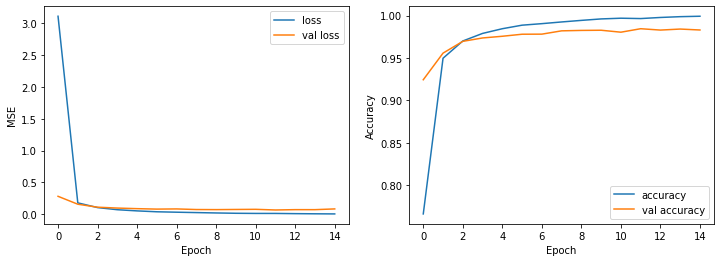

In [ ]:
# Monitor the training
plt.figure(1, figsize=(12,4))

plt.subplot(121)
plt.plot(np.array(history.history['loss']),label='loss')
plt.plot(np.array(history.history['val_loss']),label='val loss')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')

plt.subplot(122)
plt.plot(np.array(history.history['accuracy']),label='accuracy')
plt.plot(np.array(history.history['val_accuracy']),label='val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_acc = model_1.evaluate(test_images, test_labels)
print('test loss: ',np.round_(test_loss,4), 'test accuracy: ',np.round_(test_acc,4))

10000/10000 [==============================] - 1s 92us/step
test loss:  0.0649 test accuracy:  0.9846


### We have achieved 98.5% accuracy on unseen data! Not bad!

Accuracy calculates how often predictions equal labels.


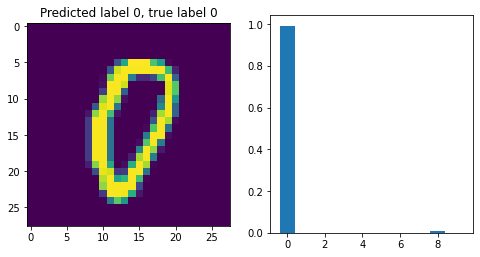

In [ ]:
#Make some predictions
predictions=model_1.predict(test_images)
i=np.random.randint(0,len(test_images))
plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.imshow(test_images[i,:,:,0])
plt.title('Predicted label {}, true label {}'.format(np.argmax(predictions[i]),test_labels[i]))
plt.subplot(122)
plt.bar(range(10),predictions[i])
plt.show()

In [ ]:
#Save your model
model_1.save('mnist_cnn.h5')

### Downloading files from Google Colab:
Once the session stops, the virtual machine you are using is deleted, including all of its contents.

**So, you must download the files; if you have many files, you can upload them on your Google Drive**

Option 1:

``from google.colab import files`` 

``files.download('mnist_cnn.h5') ``

Option 2: **mount your Google Drive to access it directly:**

`` from google.colab import drive``

``drive.mount('/content/drive')``

``model_1.save('/content/drive/My Drive/Colab Notebooks/mnist_cnn.h5')``


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model_1.save('/content/drive/My Drive/Colab Notebooks/mnist_cnn.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 5. Using our own data

***credits to [Jack](https://github.com/slack-a-jack/ml-getting-started/) for the idea + gif***

Let's make our own image and see how well the model predicts the value!

Visit: https://jspaint.app/
Follow these instructions:
- Hit **"fill"** and click anywhere on the blank image to make it black
- Go to the toolbar at the top and click: **"Image" -> "Attributes"**
- Set size to be **28x28 pixel units** and select **black & white** colours with **opaque** transparency
- Hit **"okay"**
- Back to the toolbar and select: **"View" -> "Zoom" -> "Zoom to Window"
- Now select the **Paintbrush** and select the **color white** at the bottom of the screen
- Use the left panel to change the brush **size** to be the **smallest**
- Draw a number between 0 and 9
- **File -> Save** should download the image


<center><img src="https://raw.githubusercontent.com/VKapitany/CNN_Introduction/master/Google_Colab_files/paint.gif" width="800">

** [Image source](https://github.com/slack-a-jack/ml-getting-started/blob/master/Make%20mnist.gif?raw=true)*
</center>

Now upload it by using Files>Upload to session storage


(28, 28)


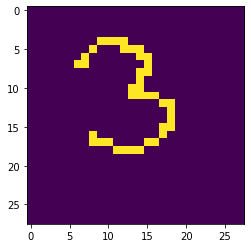

In [ ]:
#Load and visualise image. The images have 4 channels, so we select one of them
image = imageio.imread('/content/number_3.png')[:,:,0]
plt.imshow(image)
print(image.shape)

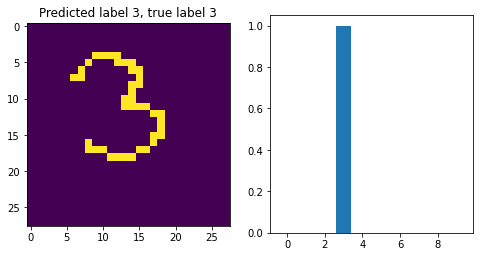

In [ ]:
#Predict 
true_label = 3 #what number you drew

image = image.reshape((1,28,28,1))
predictions=model_1.predict(image)
plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.imshow(image[0,:,:,0])
plt.title('Predicted label {}, true label {}'.format(np.argmax(predictions[0]),true_label))
plt.subplot(122)
plt.bar(range(10),predictions[0])
plt.show()

Make an image to fool the algorithm. Maybe draw a two that looks like a 7, or add an extra pixel somewhere (single pixel attack)!

(28, 28)


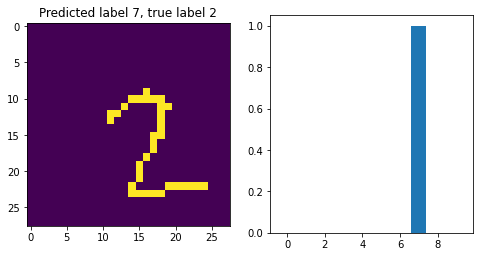

In [ ]:
image = imageio.imread('/content/number_2.png')[:,:,0]
print(image.shape)
true_label = 2
image = image.reshape((1,28,28,1))
predictions=model_1.predict(image)
plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.imshow(image[0,:,:,0])
plt.title('Predicted label {}, true label {}'.format(np.argmax(predictions[0]),true_label))
plt.subplot(122)
plt.bar(range(10),predictions[0])
plt.show()

---
# **Part 2: Let's understand properly what these CNNs actually do**

### Let's load in some data from Github *(more about Github in next session w/ Ilya).* 

In [ ]:
# Clone the repository I made for this introduction into your virtual machine
! git clone https://github.com/VKapitany/CNN_Introduction/

Cloning into 'CNN_Introduction'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 41 (delta 6), reused 37 (delta 5), pack-reused 0
Unpacking objects: 100% (41/41), done.


We can navigate inside the repository using bash commands, if we want to (similar in Jupyter)
  - ``!ls`` gives contents of the repository we are currently in
  - ``%cd..`` makes us go to a one layer higher repository
  - ``%cd 'path'`` opens up a repository with filepath 'path'


In [ ]:
!ls 

CNN_Introduction  drive  mnist_cnn.h5  sample_data


In [ ]:
%cd ..

/


In [ ]:
!ls

CNN_Introduction  drive  mnist_cnn.h5  sample_data


In [ ]:
cd CNN_Introduction/

/content/CNN_Introduction


In [ ]:
cd Google_Colab_files/

/content/CNN_Introduction/Google_Colab_files


### Load an image. It's an RGB image, so it has 3 channels. For simplicity, let's only consider the red channel.


In [ ]:
#If we are in Google_Colab_Files
img = imageio.imread('bee.jpg')

#Or equivalently
img = imageio.imread('/content/CNN_Introduction/Google_Colab_files/bee.jpg')[:,:,0]

(120, 120, 1)


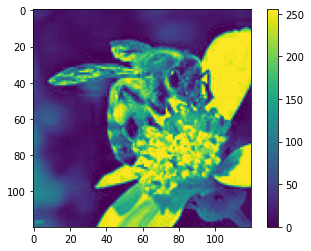

'Image adapted from https://commons.wikimedia.org/wiki/Apis_(insect)#/media/File:Beatrice_the_Honey_Bee_(7836716730).jpg'

In [ ]:
img=img.reshape(img.shape[0],img.shape[1],1)
print(img.shape)
plt.imshow(img[:,:,0])
plt.colorbar()
plt.show()
lst=np.asarray([img,])
"""Image adapted from https://commons.wikimedia.org/wiki/Apis_(insect)#/media/File:Beatrice_the_Honey_Bee_(7836716730).jpg"""

Let's make the simplest possible CNN: 1 filter, 1 layer

In [ ]:
inp = Input(shape=(img.shape[0],img.shape[1],1),name='inp_image')
out = Conv2D(1, (3,3), name='layer_1',padding='valid')(inp)

model_2 = Model(inputs=inp,outputs=out, name='Image_processing')
model_2.summary()

Model: "Image_processing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp_image (InputLayer)       (None, 120, 120, 1)       0         
_________________________________________________________________
layer_1 (Conv2D)             (None, 118, 118, 1)       10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


### We can access  the **filters and biases (weights)** using the [``get_weights``](https://keras.io/api/layers/base_layer/#get_weights-method) and [``set_weights``](https://keras.io/api/layers/base_layer/#set_weights-method) API.




In [ ]:
conv_layer_weights=model_2.layers[1].get_weights() #layer 1 in python indexing
print('Filter\n',conv_layer_weights[0][:,:,0,0],'\nBias\n',conv_layer_weights[1])

Filter
 [[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]] 
Bias
 [0.]


The weights are organised as a *list* (kernels, biases)

The kernels are organised as: (3,3,1,1) = rows, columns, input feautures/channels, output features

### Now, let's do some basic, controlled image processing, **e.g. let's detect edges. This is a simple form of feature extraction**


In [ ]:
"""Kernels adapted from https://en.wikipedia.org/wiki/Kernel_(image_processing)"""

identity=np.asarray([[0, 0, 0],
                     [0, 1, 0],
                     [0, 0, 0]])
zeros = np.asarray([[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]]) # np.zeros((3,3))
edge=np.asarray([[-1, 0, 1],
                 [0, 0, 0],
                 [1, 0, -1]])
edge_2=np.asarray([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])
edge_3=np.asarray([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
sharpen=np.asarray([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
box_blur=(1/9)*np.asarray([[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]])
gaussian_blur=(1/16)*np.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]])

conv_layer_weights[0][:,:,0,0]=edge_2 
model_2.layers[1].set_weights(conv_layer_weights)

""" even if there's only 1 kernel, I need to 
make sure that I define which kernel I am changing, by fully indexing it"""



print('Layer 1: \nkernel 1: \n',conv_layer_weights[0][:,:,0,0])


Layer 1: 
kernel 1: 
 [[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]]


### We now have a model loaded with a single edge detection kernel. Let's use this model to detect edges in the image!


In [ ]:
predictions=model_2.predict(img)


ValueError: ignored

<center><img src="https://raw.githubusercontent.com/VKapitany/CNN_Introduction/master/Google_Colab_files/error.png" width=300>

**[Image Source](https://cdn.postgradproblems.com/wp-content/uploads/2015/03/57d4bf782f99aac69f990d66c7c63b46.png)*
</center>

Notice how when we call ``model.summary()``, the layers' first dimension is ``None``? That's because tensorflow expects the first dimension to be the index of a *list* or *array* of inputs, such as with the MNIST digits. 

<center><img src="https://raw.githubusercontent.com/VKapitany/CNN_Introduction/master/Google_Colab_files/None.png" width=300>


</center>


**So, we must reshape our input**, in the format:
``number of inputs, rows, columns, channels``



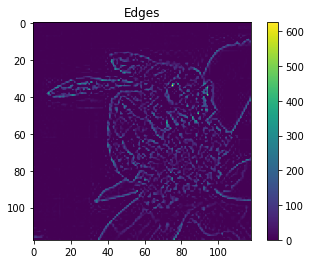

In [ ]:
img=img.reshape(1,120,120,1)
predictions=model_2.predict(img)
plt.imshow(predictions[0,:,:,0])
plt.title('Edges')
plt.colorbar()

# Summary:
Google Colab:

  - Pros:

    - Easy to collaborate 
    - GPU + use somebody else's hardware
    - Don't need to manage anaconda environments
    - Virtual machine is private, should be safe

  - Cons: 
    
    - Bit trickier to load data than if you use your own hard drive
    - Runtime can disconnect -> large risk of data loss
    - Technically data not on UK/EU servers 

  - Pay attention to:
    - Download important data before changing runtime/closing session
    - Disconnects after 12 hours/some idle period

Covnolutional Neural Networks

  - Pros:
    -  Sparse connections between layers (smaller computational load)
    -   Parameter sharing (good for image processing)
    -   Feature extraction capabilities (good for image processing)
  -Cons:
    - Sometimes you need full connectivity
    - Less intuitive

- Pay attention to:
  - architecture input shape must have ``rows,columns,channels``
  - input data must be ``number of inputs, rows, columns, channels``
  - need to flatten CNN to connect to a dense layer
  - downsampling (MaxPooling2D), upsampling (UpSampling2D) to change the feature map shape while using CNNs.

 





# A small 2 layer CNN with RGP input (3 channels), to play around with and familiarise yourself!



(120, 120, 3)


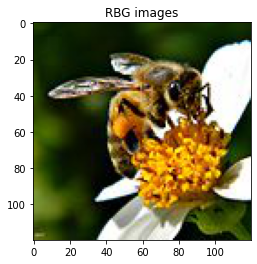

In [ ]:
img = imageio.imread('/content/CNN_Introduction/Google_Colab_files/bee.jpg')
print(img.shape)
img=img.reshape(1,120,120,3)
plt.title('RBG images')
plt.imshow(img[0,:,:,:])
plt.show()

Model: "Edge_detection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp_image (InputLayer)       (None, 120, 120, 3)       0         
_________________________________________________________________
layer_1 (Conv2D)             (None, 118, 118, 2)       56        
_________________________________________________________________
layer_2 (Conv2D)             (None, 116, 116, 1)       19        
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


Dimension of filters in layer 1: 
row: 3 
columns: 3 
channels/filters in: 3 
filters out: 2 
total number of kernels: 6


Layer 1: 
kernel 1: 
 [[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]] 
kernel 2: 
 [[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]]
Layer 2: 
kernel 1: 
 [[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]] 
kernel 2: 
 [[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


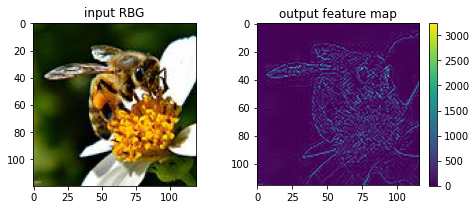

In [ ]:
# Apply a simple convolution using the tensorflow API

inp = Input(shape=(120,120,3),name='inp_image')
conv = Conv2D(2, (3,3), name='layer_1',padding='valid')(inp)
out = Conv2D(1, (3,3), name='layer_2',padding='valid',activation='relu')(conv)

model_3 = Model(inputs=inp,outputs=out, name='Edge_detection')
model_3.summary()

"""Kernels adapted from https://en.wikipedia.org/wiki/Kernel_(image_processing)"""
identity=np.asarray([[0, 0, 0],
                     [0, 1, 0],
                     [0, 0, 0]])
zeros = np.asarray([[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]]) # np.zeros((3,3))
edge=np.asarray([[-1, 0, 1],
                 [0, 0, 0],
                 [1, 0, -1]])
edge_2=np.asarray([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])
edge_3=np.asarray([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
sharpen=np.asarray([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
box_blur=(1/9)*np.asarray([[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]])
gaussian_blur=(1/16)*np.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]])

#Get the weights (kernels, biases)
conv_layer_1_weights=model_3.layers[1].get_weights() 
conv_layer_2_weights=model_3.layers[2].get_weights()

print('\n\nDimension of filters in layer 1:',
      '\nrow:',conv_layer_1_weights[0].shape[0],
      '\ncolumns:',conv_layer_1_weights[0].shape[1],
      '\nchannels/filters in:',conv_layer_1_weights[0].shape[2],
      '\nfilters out:',conv_layer_1_weights[0].shape[3],
      '\ntotal number of kernels:',conv_layer_1_weights[0].shape[2]*conv_layer_1_weights[0].shape[3])

# Change the type of kernel to see the resulting behaviour. Hint: to isolate one behaviour, use
# zeros or identity ####################################################

conv_layer_1_weights[0][:,:,0,0]=edge_2

conv_layer_1_weights[0][:,:,0,1]=edge_2

conv_layer_2_weights[0][:,:,0,0]=sharpen

conv_layer_2_weights[0][:,:,1,0]= identity

#uncomment next line to change bias of layer 2 to 1 (default is 0)

#conv_layer_2_weights[1] = 1

########################################################################

# Reset the weights with the target kernels. 
model_3.layers[1].set_weights(conv_layer_1_weights)
model_3.layers[2].set_weights(conv_layer_2_weights)


print('\n\nLayer 1: \nkernel 1: \n',conv_layer_1_weights[0][:,:,0,0],'\nkernel 2: \n', conv_layer_1_weights[0][:,:,0,1])
print('Layer 2: \nkernel 1: \n',conv_layer_2_weights[0][:,:,0,0], '\nkernel 2: \n', conv_layer_2_weights[0][:,:,1,0])

predictions=model_3.predict(img)

plt.figure(1, figsize=(8,3))
plt.subplot(121)
plt.imshow(img[0,:,:])
plt.title('input RBG')
plt.subplot(122)
plt.imshow(predictions[0,:,:,0])
plt.title('output feature map')
plt.colorbar()
plt.show()